In [1]:
%matplotlib inline

import os, sys, gc
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool, Process

import itertools
from modules.kidera import score_positions, score_sequence

import warnings
warnings.filterwarnings('ignore')

In [12]:
def get_obj_size(obj):
    marked = {id(obj)}
    obj_q = [obj]
    sz = 0

    while obj_q:
        sz += sum(map(sys.getsizeof, obj_q))

        # Lookup all the object reffered to by the object in obj_q.
        # See: https://docs.python.org/3.7/library/gc.html#gc.get_referents
        all_refr = ((id(o), o) for o in gc.get_referents(*obj_q))

        # Filter object that are already marked.
        # Using dict notation will prevent repeated objects.
        new_refr = {o_id: o for o_id, o in all_refr if o_id not in marked and not isinstance(o, type)}

        # The new obj_q will be the ones that were not marked,
        # and we will update marked with their ids so we will
        # not traverse them again.
        obj_q = new_refr.values()
        marked.update(new_refr.keys())

    return sz

In [18]:
# n_str = 5000000
# df = pd.DataFrame()
# for chunk in tqdm_notebook(pd.read_csv('output/tmp/CMV_nmp.csv', chunksize=n_str)):
#     df = pd.concat([df, chunk[chunk["%Rank"] <= 0.5]])

In [73]:
folder = 'output/tmp/'
infections = [i for i in os.listdir(folder)]
viruses = ['CMV_nmp.csv',
           'HCV_nmp.csv',
           'YFV_nmp.csv',
           'EBV_nmp.csv', 
           'HIV-1_nmp.csv']
infections

['CMV_nmp.csv',
 'HCV_nmp.csv',
 'YFV_nmp.csv',
 'CLOSdificile_nmp.csv',
 'EBV_nmp.csv',
 'MYPLsynoviae_nmp.csv',
 'YERSpseudotuberculosis_nmp.csv',
 'HIV-1_nmp.csv',
 'SHGLsonnei_nmp.csv',
 'SLMLenteritidis_nmp.csv',
 'MYPLpneumoniae_nmp.csv',
 'MYBTsmegmatis_nmp.csv',
 'CPBTjejuni_nmp.csv',
 'CLMDtrachomatis_nmp.csv']

In [74]:
for infection in infections:
    if infection in viruses:
        print(infection)

CMV_nmp.csv
HCV_nmp.csv
YFV_nmp.csv
EBV_nmp.csv
HIV-1_nmp.csv


In [75]:
def filter_binding(filepath, rank):
    print(filepath)
    df = pd.DataFrame()
    for chunk in tqdm_notebook(pd.read_csv(folder + filepath, chunksize=n_str)):
        df = pd.concat([df, chunk[chunk["%Rank"] <= rank]])
    return df

def filter_(filepath):
    if filepath in viruses:
        return filter_binding(filepath, rank=2)
    else:
        return filter_binding(filepath, rank=.5)

n_str = 25000000

with Pool(processes=len(infections)) as pool:
    result = pool.map(filter_, infections)

df = pd.concat(result)

HCV_nmp.csv
CLOSdificile_nmp.csv
EBV_nmp.csv
CLMDtrachomatis_nmp.csv
SHGLsonnei_nmp.csv
YERSpseudotuberculosis_nmp.csv
MYBTsmegmatis_nmp.csv
CPBTjejuni_nmp.csv
MYPLpneumoniae_nmp.csv
HIV-1_nmp.csv
MYPLsynoviae_nmp.csv
SLMLenteritidis_nmp.csv
CMV_nmp.csv
YFV_nmp.csv
















In [14]:
get_obj_size(df) / 8 / 1024 / 1024

2396.6356521844864

In [76]:
df.shape

(15690217, 5)

In [77]:
df.head()

,HLA,Peptide,%Rank,Origin_protein,Origin_name
1116,HLA-C*02:02,FAYDAQEDCLYEL,1.0807,UL29_HCMVA,CMV
2305,HLA-C*02:02,FVDDVGLYSTALF,1.1146,UL78_HCMVA,CMV
3067,HLA-C*02:02,MAYSRQPDRAAFY,1.2563,TRM1_HCMVA,CMV
3562,HLA-C*02:02,FTYDEHLYVVNNL,0.7089,TRM1_HCMVA,CMV
4432,HLA-C*02:02,FSYGNSVDNLRRL,1.5836,US08_HCMVA,CMV


In [78]:
df.to_csv('milab_data.csv', index=False)

In [33]:
aa = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,\
      'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,\
      'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

def count_freq(df, hla):
#     data = pd.read_csv(filepath, index_col=False, sep=" ")
#     binding = data[data.ix[:,2] <= 500]
    ndf = df[df['Peptide'].str.len()==9]
    binding = ndf[ndf['HLA']==hla]
    freq = np.zeros((20,9))
    for line in binding.ix[:,1]:
        for i, a in enumerate(line):
            try:
                freq[int(aa[a]), i] = freq[aa[a],i]+1
            except KeyError:
                pass
    freq_norm = np.true_divide(freq, 409088)
    freq_norm_r = np.round(freq_norm, 2)
    aa_df = pd.DataFrame(freq_norm_r, index=[i for i in sorted(aa.keys())], columns=np.arange(1,10))
    return aa_df

def plot_freq(aa_df, axes):
#     fig = plt.figure(figsize=(3, 5))
    sns.heatmap(aa_df, ax = axes)
#     plt.show()

def plot_entr(input_df, axes):
    df = pd.DataFrame([stats.entropy(input_df[i], base=2) for i in input_df.columns], columns = ['entropy'])
    df['position'] = input_df.columns
    clrs = ['grey' if x > 3 else 'red' for x in df['entropy']]
#     fig = plt.figure(figsize=(5, 3))
    sns.barplot(data=df, x='position', y='entropy', palette = clrs, ax = axes)

In [24]:
np.sort(df.HLA.unique())

array(['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*02:02', 'HLA-A*02:03',
       'HLA-A*02:05', 'HLA-A*02:06', 'HLA-A*02:07', 'HLA-A*02:11',
       'HLA-A*02:17', 'HLA-A*03:01', 'HLA-A*11:01', 'HLA-A*23:01',
       'HLA-A*24:02', 'HLA-A*24:03', 'HLA-A*25:01', 'HLA-A*26:01',
       'HLA-A*29:02', 'HLA-A*30:01', 'HLA-A*30:02', 'HLA-A*31:01',
       'HLA-A*32:01', 'HLA-A*33:01', 'HLA-A*33:03', 'HLA-A*68:01',
       'HLA-A*68:02', 'HLA-B*07:02', 'HLA-B*08:01', 'HLA-B*14:02',
       'HLA-B*15:01', 'HLA-B*15:03', 'HLA-B*15:10', 'HLA-B*27:02',
       'HLA-B*27:05', 'HLA-B*35:01', 'HLA-B*35:02', 'HLA-B*35:03',
       'HLA-B*35:14', 'HLA-B*37:01', 'HLA-B*38:01', 'HLA-B*39:01',
       'HLA-B*39:05', 'HLA-B*39:06', 'HLA-B*40:01', 'HLA-B*40:02',
       'HLA-B*40:06', 'HLA-B*41:02', 'HLA-B*42:01', 'HLA-B*44:02',
       'HLA-B*44:03', 'HLA-B*45:01', 'HLA-B*48:01', 'HLA-B*50:01',
       'HLA-B*51:01', 'HLA-B*52:01', 'HLA-B*53:01', 'HLA-B*55:01',
       'HLA-B*55:02', 'HLA-B*57:01', 'HLA-B*57:03', 'HLA-B*58:

In [27]:
A0101 = count_freq(df, 'HLA-A*01:01')
A0205 = count_freq(df, 'HLA-A*02:05')

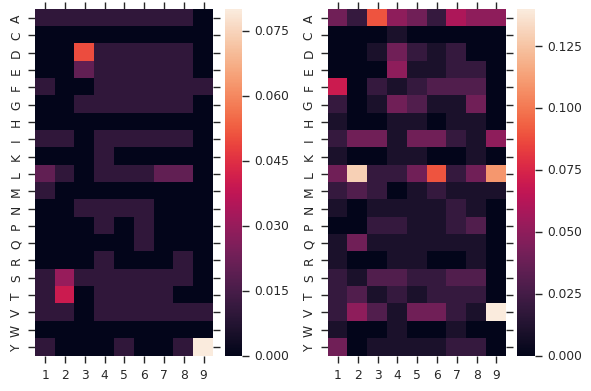

In [38]:
# sns.set()
# sns.set_style("dark")
sns.set_context("paper")
figs, axs = plt.subplots(1,2)

plot_freq(A0101, axs[0])
plot_freq(A0205, axs[1])
plt.tight_layout()

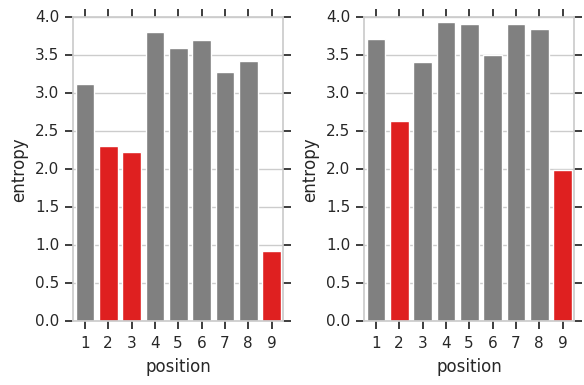

In [32]:
figs, axs = plt.subplots(1,2)

plot_entr(A0101, axs[0])
plot_entr(A0205, axs[1])
plt.tight_layout()

In [40]:
sumentrlist = {}
for hla in tqdm_notebook(np.sort(df.HLA.unique())):
    entr = 0
    freq = count_freq(df, hla)
    for col in freq:
        entr += stats.entropy(freq[col], base=2)
    sumentrlist[hla] = entr

In [43]:
data = pd.DataFrame.from_dict(sumentrlist, orient="index")
data['name'] = data.index
data = data.replace([np.inf, -np.inf], np.nan).dropna()
data = data.sort_values(by='name')
data.index = range(len(data))
data.head()

,0,name
0,26.354611,HLA-A*01:01
1,29.793796,HLA-A*02:01
2,29.774254,HLA-A*02:02
3,29.461586,HLA-A*02:03
4,30.809960,HLA-A*02:05


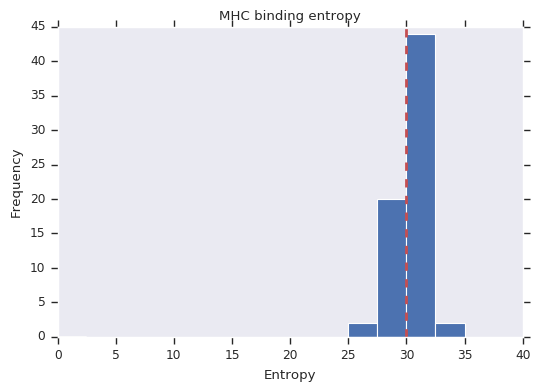

In [44]:
binz = np.arange(0,40,2.5)
plt.hist(data[0], bins=binz)
plt.title("MHC binding entropy")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
thresh = 30
plt.axvline(x=thresh, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [62]:
anchorpos = {}
for hla in tqdm_notebook(np.sort(df.HLA.unique())):
    freq = count_freq(df, hla)
    pos = np.where(stats.entropy(freq, base=2) < 3)
    anchorpos[hla] = [i + 1 for i in pos[0].tolist()]

In [66]:
anchor_df = pd.DataFrame.from_dict(anchorpos, orient='index')
anchor_df.to_csv("output/anchorpos.csv")

In [71]:
data.columns = ["Entropy", "HLA"]
data[data["Entropy"]<=27.5]

,Entropy,HLA
0,26.354611,HLA-A*01:01
32,26.756948,HLA-B*27:05


In [72]:
anchorpos

{'HLA-A*01:01': [2, 3, 9],
 'HLA-A*02:01': [2, 9],
 'HLA-A*02:02': [2, 9],
 'HLA-A*02:03': [2, 9],
 'HLA-A*02:05': [2, 9],
 'HLA-A*02:06': [2, 9],
 'HLA-A*02:07': [2, 9],
 'HLA-A*02:11': [2, 9],
 'HLA-A*02:17': [2, 9],
 'HLA-A*03:01': [2, 9],
 'HLA-A*11:01': [2, 9],
 'HLA-A*23:01': [2, 9],
 'HLA-A*24:02': [2, 9],
 'HLA-A*24:03': [2, 9],
 'HLA-A*25:01': [2, 9],
 'HLA-A*26:01': [2, 9],
 'HLA-A*29:02': [9],
 'HLA-A*30:01': [1, 3, 9],
 'HLA-A*30:02': [9],
 'HLA-A*31:01': [9],
 'HLA-A*32:01': [2, 9],
 'HLA-A*33:01': [9],
 'HLA-A*33:03': [9],
 'HLA-A*68:01': [2, 9],
 'HLA-A*68:02': [2, 9],
 'HLA-B*07:02': [2, 9],
 'HLA-B*08:01': [2, 5, 9],
 'HLA-B*14:02': [9],
 'HLA-B*15:01': [2, 9],
 'HLA-B*15:03': [9],
 'HLA-B*15:10': [2, 9],
 'HLA-B*27:02': [2, 9],
 'HLA-B*27:05': [2, 9],
 'HLA-B*35:01': [2, 9],
 'HLA-B*35:02': [2, 9],
 'HLA-B*35:03': [2, 9],
 'HLA-B*35:14': [2, 9],
 'HLA-B*37:01': [2, 9],
 'HLA-B*38:01': [2, 9],
 'HLA-B*39:01': [2, 9],
 'HLA-B*39:05': [2, 9],
 'HLA-B*39:06': [2, 9],
 'HL